In [1]:
!pip install -q kaggle

from google.colab import files
files.upload()
# Chọn file kaggle.json tải về ở bước 2 để tải lên

!mkdir '/root/.kaggle'
!cp kaggle.json '/root/.kaggle'
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

 96% 45.0M/47.0M [00:03<00:00, 23.0MB/s]
100% 47.0M/47.0M [00:03<00:00, 15.8MB/s]


In [3]:
!unzip -q /content/shoe-vs-sandal-vs-boot-dataset-15k-images.zip

In [4]:
import os

path_data = '/content/Shoe vs Sandal vs Boot Dataset'

os.mkdir('dataset')

os.chdir('./dataset')
os.mkdir('train')
os.mkdir('test')

path_train = '/content/dataset/train'
path_test = '/content/dataset/test'

folders = os.listdir(path_data)

os.chdir(path_train)
for folder in folders:
    os.mkdir(folder)

os.chdir(path_test)
for folder in folders:
    os.mkdir(folder)

os.chdir('/content')

### Train Test Split

In [5]:
import cv2

for folder in folders:
    images = os.listdir(f'{path_data}/{folder}')
    print(f'load {folder}')
    i = 1
    for image in images:
        file_name = f'{i}.jpg'
        img = cv2.imread(f'{path_data}/{folder}/{image}')
        if i < int(0.9*len(images)):
            os.chdir(f'{path_train}/{folder}')
            cv2.imwrite(file_name, img)
            i = i+1
        else:
            # luu vao test
            os.chdir(f'{path_test}/{folder}')
            cv2.imwrite(file_name, img)
            i = i+1
os.chdir('/content')

load Sandal
load Shoe
load Boot


### DataLoader

In [42]:
import torch
from torchvision import datasets, transforms


# augment image
transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=path_train, transform=transform, target_transform=None)
test_dataset = datasets.ImageFolder(root=path_test, transform=transform)

In [7]:
class_name = train_dataset.classes
class_name

['Boot', 'Sandal', 'Shoe']

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset, batch_size=32,shuffle=True)
test_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=False)

### Building Model

In [9]:
from torch import nn

# building model
class Model(nn.Module):
    def __init__(self, input_shape: int, out_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*13*13, 512),
            nn.Linear(512, 64),
            nn.Linear(64, out_shape)
        )
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [11]:
model = Model(3, len(class_name)).to(device)

In [12]:
from prompt_toolkit.shortcuts.progress_bar.base import E
# show cnn use torchinfo
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model, input_size=[32, 3, 64, 64])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [32, 3]                   --
├─Sequential: 1-1                        [32, 32, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 16, 62, 62]          448
│    └─ReLU: 2-2                         [32, 16, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 32, 60, 60]          4,640
│    └─ReLU: 2-4                         [32, 32, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 32, 30, 30]          --
├─Sequential: 1-2                        [32, 128, 13, 13]         --
│    └─Conv2d: 2-6                       [32, 64, 28, 28]          18,496
│    └─ReLU: 2-7                         [32, 64, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 128, 26, 26]         73,856
│    └─ReLU: 2-9                         [32, 128, 26, 26]         --
│    └─MaxPool2d: 2-10                   [32, 128, 13, 13]         --
├─S

### Train model

In [13]:
# training
def train_step(model: torch.nn.Module,
               dataset: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
      # setup train loss, acc
      train_loss, train_acc = 0, 0

      # put model into mode train
      model.train()

      # loop
      for batch, (X, y) in enumerate(dataset):
          #send X, y to device
          X, y = X.to(device), y.to(device)

          # 1. Forward
          y_pred = model(X)

          # 2. calculate loss
          loss = loss_fn(y_pred, y)
          train_loss += loss.item()

          # 3. optimizer zero grad
          optimizer.zero_grad()

          # 4. backward
          loss.backward()

          # 5. update the optim
          optimizer.step()

          y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
          train_acc += ((y_pred_class == y).sum().item()) / len(y_pred)
      
      # adjust metric
      train_loss = train_loss / len(dataset)
      train_acc = train_acc / len(dataset)
      return train_loss, train_acc

In [14]:
# testing
def test_step(model: torch.nn.Module,
              dataset: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module
              ):
  
    # setup test loss, acc
    test_loss, test_acc = 0, 0

    # put model into eval
    model.eval()

    # loop
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataset):
            # send X, y to device
            X, y = X.to(device), y.to(device)

            # 1. forward
            test_pred = model(X)

            # 2. calculate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = torch.argmax(torch.softmax(test_pred, dim = 1), dim=1)
            test_acc += ((test_pred_class == y).sum().item()) / len(test_pred)

        #adiust metric
        test_loss = test_loss / len(dataset)
        test_acc = test_acc / len(dataset)
        return test_loss, test_acc

In [15]:
# ket hop train_step voi test_step
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int):

    # setup results
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    torch.manual_seed(42)

    # loop
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataset=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
        test_loss, test_acc = test_step(model=model, dataset=test_dataloader, loss_fn=loss_fn)

        print(f'Epoch: {epoch+1}')
        print(f'Train_loss: {train_loss:.4f}')
        print(f'Train_acc: {train_acc:.2f}')
        print(f'Test_loss: {test_loss:.4f}')
        print(f'Test_acc: {test_acc:.2f}')

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [16]:
# training
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

model_results = train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                      loss_fn=loss_fn, optimizer=optimizer, epochs=epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train_loss: 0.3953
Train_acc: 0.84
Test_loss: 0.2137
Test_acc: 0.93
Epoch: 2
Train_loss: 0.2006
Train_acc: 0.93
Test_loss: 0.1893
Test_acc: 0.93
Epoch: 3
Train_loss: 0.1427
Train_acc: 0.95
Test_loss: 0.1122
Test_acc: 0.96
Epoch: 4
Train_loss: 0.1176
Train_acc: 0.96
Test_loss: 0.0912
Test_acc: 0.97
Epoch: 5
Train_loss: 0.0981
Train_acc: 0.97
Test_loss: 0.0691
Test_acc: 0.98


In [18]:
# kiem tra
import torchvision
import matplotlib.pyplot as plt
from typing import List
def pred_and_plot_img(model: torch.nn.Module,
                      image_path: str,
                      class_name: List[str] = None,
                      transform=None,
                      device: torch.device = device):
    # 1. load in image and convert
    target_img = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Devide the image pixel[0, 1]
    target_img = target_img / 255.

    # 3. transform
    if transform:
        target_image = transform(target_img)
    
    # 4. 
    model.to(device)
    
    # 5. turn on model
    model.eval()
    with torch.inference_mode():
        # them mot kic thuoc bo sung cho anh
        target_img = target_image.unsqueeze(dim=0)
        

        # make pred
        img_pred = model(target_img.to(device))
    
    # 6. convert logist
    img_pred_prob = torch.softmax(img_pred, dim=1)

    img_pred_class = torch.argmax(img_pred_prob, dim=1)

    # sap xep lai cac thu tu cua anh va show anh
    plt.imshow(target_img.squeeze().permute(1,2,0))
    if class_name:
        title = f'Pred: {class_name[img_pred_class.cpu()]} | Prob: {img_pred_prob.max().cpu():.2f}'
    else:
        title = f"Pred: {img_pred_class} | Prob: {img_pred_prob.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


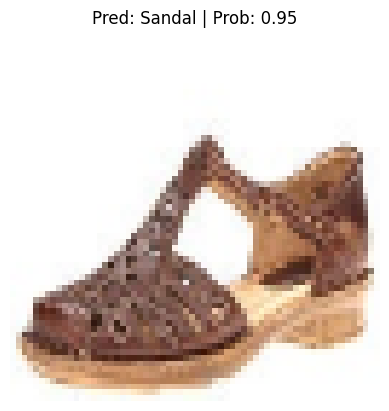

In [19]:
# pred
path_img = '/content/dataset/test/Sandal/4500.jpg'
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])
pred_and_plot_img(model=model, image_path=path_img, class_name=class_name, transform=custom_image_transform, device=device)

### Plot loss and acc

In [20]:
# plot
from typing import Tuple, Dict, List
def plot_loss_acc(results: Dict[str, List[float]]):

    # get the loss
    train_loss = results['train_loss']
    test_loss = results['test_loss']

    # get the acc
    train_acc = results['train_acc']
    test_acc = results['test_acc']

    epochs = range(len(results['train_loss']))

    # setup figure
    plt.figure(figsize=(15, 7))

    # plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # plot acc
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='train_acc')
    plt.plot(epochs, test_acc, label='test_acc')
    plt.title('Acc')
    plt.xlabel('Epochs')
    plt.legend();

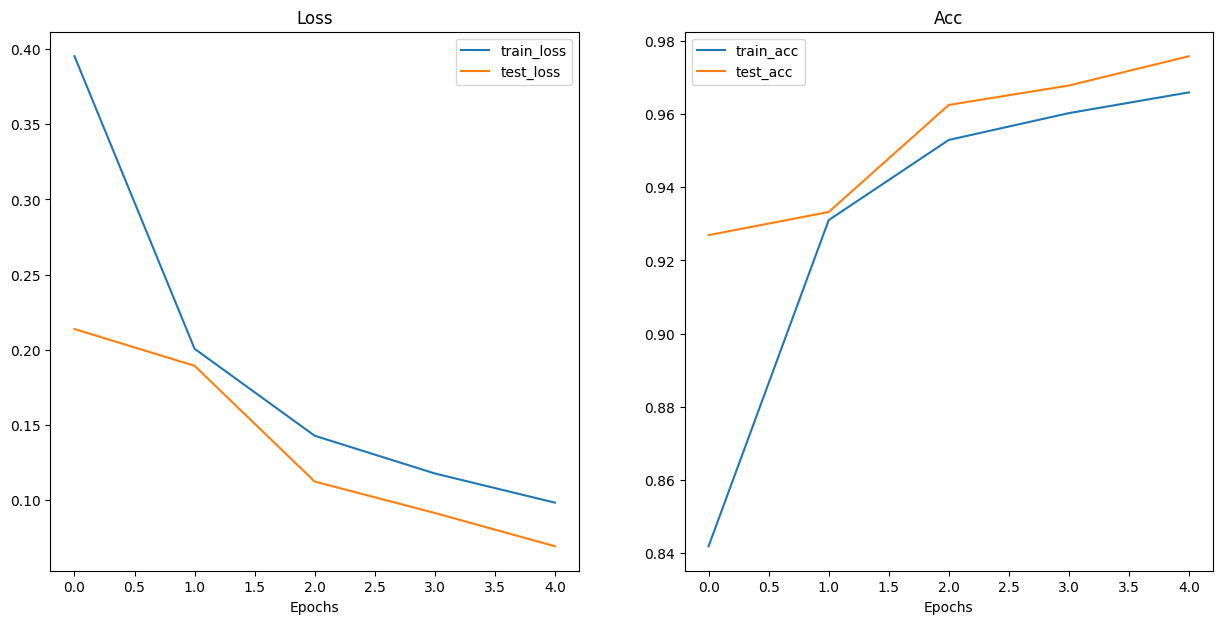

In [21]:
plot_loss_acc(model_results)

### Thời gian dự đoán model pytorch

Final top pred: Sandal
Time: 2.68 ms


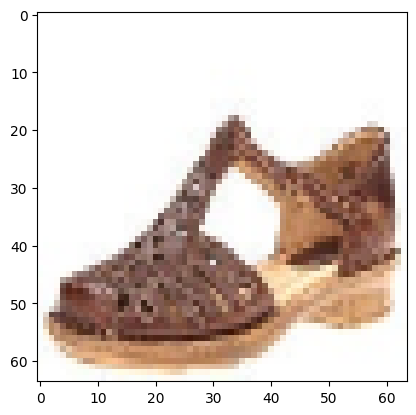

In [59]:
import time
model = model.to('cuda:0')
target_img = torchvision.io.read_image(str('/content/dataset/test/Sandal/4500.jpg')).type(torch.float32)
transform_pred = transforms.Compose([
    transforms.Resize((64, 64))
])

target_img = target_img/255
target_img = transform_pred(target_img)
model.eval()
start = time.time()
with torch.inference_mode():
    # them mot kic thuoc bo sung cho anh
    target_img = target_img.unsqueeze(dim=0)
    

    # make pred
    img_pred = model(target_img.to(device))
    # img_pred = model(target_img)

# 6. convert logist
img_pred_prob = torch.softmax(img_pred, dim=1)

import numpy as np
idx = torch.argmax(img_pred_prob, dim=1)
end = time.time()
time1 = np.round((end-start) * 1000, 2)

print('Final top pred: ' + class_name[idx])
print('Time: ' + str(time1) + ' ms')
plt.imshow(target_img.squeeze().permute(1,2,0))


### convert to ONNX

In [ ]:
!pip install onnx
!pip install onnxruntime

In [27]:
import torch.onnx
import torch

dummy_input = torch.randn(1, 3, 64, 64)
model = model.to('cpu')
torch.onnx.export(model, dummy_input, 'model.onnx')

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [28]:
!pip install onnxruntime-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 MB 9.3 MB/s eta 0:00:00


In [34]:
import torch
import numpy as np
import onnxruntime

# run the model on the backend
model_onnx = onnxruntime.InferenceSession('/content/model.onnx', providers=['CUDAExecutionProvider'])

# lấy tên của đầu vào đầu tiên của mô hình
input_name = model_onnx.get_inputs()[0].name
image = np.random.randn(1, 3, 64, 64).astype(np.float32)

ort_inputs = {input_name: image}
ort_outs = model_onnx.run(None, ort_inputs)
print(ort_outs)

[array([[-37.950314,  20.895424,  36.397366]], dtype=float32)]


In [53]:
def preprocess(input_data):
    # convert the input data into the float32 input
    img_data = input_data.astype('float32')

    #normalize
    mean_vec = np.array([0.485, 0.456, 0.406])
    stddev_vec = np.array([0.229, 0.224, 0.225])
    norm_img_data = np.zeros(img_data.shape).astype('float32')
    for i in range(img_data.shape[0]):
        norm_img_data[i,:,:] = (img_data[i,:,:]/255)
        
    #add batch channel
    norm_img_data = norm_img_data.reshape(1, 3, 64, 64).astype('float32')
    return norm_img_data

def softmax(x):
    x = x.reshape(-1)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def postprocess(result):
    return softmax(np.array(result)).tolist()

Image size:  (64, 64)
Final top prediction is: Sandal
Inference time: 1.43 ms


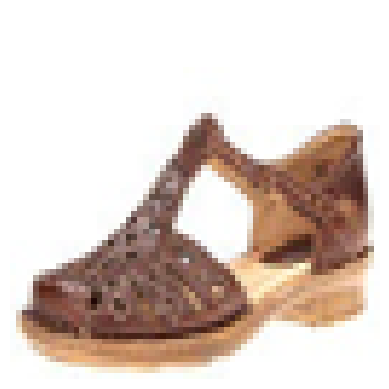

In [60]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open('/content/dataset/test/Sandal/4500.jpg')
image = image.resize((64, 64))
# image = Image.open('images/plane.jpg')

print("Image size: ", image.size)
image_data = np.array(image).transpose(2, 0, 1)
input_data = preprocess(image_data)
import time
start = time.time()
raw_result = model_onnx.run([], {input_name: input_data})
# print(raw_result)
end = time.time()
res = postprocess(raw_result)
# res = torch.softmax(raw_result, dim=1).tolist()
time2 = np.round((end - start) * 1000, 2)
idx = np.argmax(res)
print('========================================')
print('Final top prediction is: ' + class_name[idx])
print('========================================')

print('========================================')
print('Inference time: ' + str(time2) + " ms")
print('========================================')

plt.axis('off')
display_image = plt.imshow(image)

In [83]:
path = '/content/dataset/test/Boot'
time_pytorch = []
time_onnx = []
images = os.listdir(path)
count = 0
for image in images:
    img_path = f'{path}/{image}'

    # predict pytorch
    model = model.to(device)
    target_img = torchvision.io.read_image(str(img_path)).type(torch.float32)
    transform_pred = transforms.Compose([
        transforms.Resize((64, 64))
    ])

    target_img = target_img/255
    target_img = transform_pred(target_img)
    model.eval()
    start = time.time()
    with torch.inference_mode():
        # them mot kic thuoc bo sung cho anh
        target_img = target_img.unsqueeze(dim=0)
        

        # make pred
        img_pred = model(target_img.to(device))
        # img_pred = model(target_img)

    # 6. convert logist
    img_pred_prob = torch.softmax(img_pred, dim=1)

    import numpy as np
    idx = torch.argmax(img_pred_prob, dim=1)
    end = time.time()
    time1 = np.round((end-start) * 1000000, 2)
    time_pytorch.append(time1)

    # predict ONNX
    image = Image.open(img_path)
    image = image.resize((64, 64))
    # image = Image.open('images/plane.jpg')

    image_data = np.array(image).transpose(2, 0, 1)
    input_data = preprocess(image_data)
    import time
    start = time.time()
    raw_result = model_onnx.run([], {input_name: input_data})
    # print(raw_result)
    end = time.time()
    time2 = np.round((end - start) * 1000000, 2)
    time_onnx.append(time2)
    count = count + 1
    if count == 100:
        break

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [82]:
print(time_onnx)
print(time_pytorch)

[1117.47, 823.74, 795.6, 797.99, 814.91]
[1719.0, 1161.34, 1201.87, 1085.52, 1186.61]


In [88]:
array = []
count = 0
for i in range(len(time_onnx)):
    if (time_onnx[i] - time_pytorch[i]) < 0:
        count = count + 1
    array.append(time_onnx[i] - time_pytorch[i])
print(f'So lan onnx nhanh hon torch la: {count} / {len(time_onnx)}')

So lan onnx nhanh hon torch la: 98 / 100


In [85]:
def plot_time(time_pytorch, time_onnx):
    count = range(len(time_pytorch))

    # setup figure
    plt.figure(figsize=(15, 7))

    # plot time
    plt.plot(count, array, label='time_onnx - time_pytorch')
    # plt.plot(count, time_pytorch, label='time_onnx')
    plt.title('Time Inference')
    plt.xlabel('Epochs')
    plt.legend()


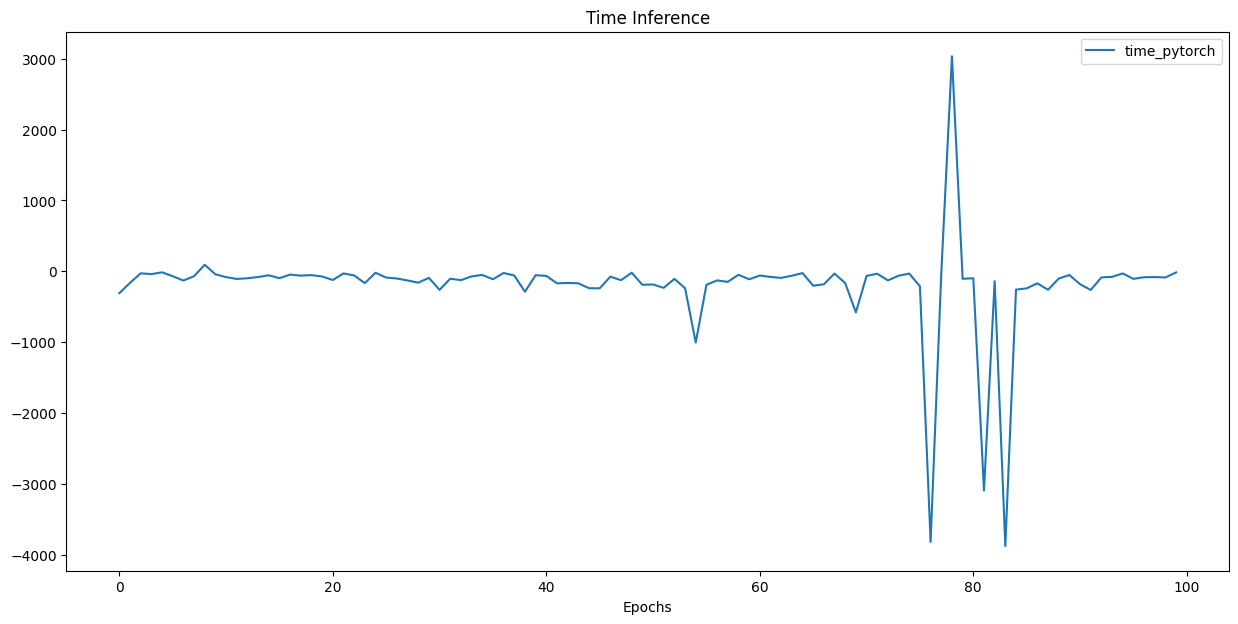

In [86]:
plot_time(array, time_onnx)